# Random Numbers and Their Use in HEP <br> aka - Use and abuse of random number generators

 * David Lange (Princeton University) -- david.lange@cern.ch 
 * And with thanks to Dan Riley (Cornell University) who developed much of this material for previous CoDas-HEP schools. 

## Lesson plan
  * Where does HEP rely on (pseudo)random numbers?
  * Random number generators
  * An example: Linear Congruential Generators (LCG)
  * Exercise 1
  * Good and bad examples of RNGs
  * Exercise 2

# Where does HEP rely on (pseudo)random numbers?

Good random number sequences are critical for a variety of important techniques

  * Monte Carlo physics generators (eg, Pythia)
  * Monte Carlo detector simulation (eg, Geant4)
  * Monte Carlo digitization (eg, electronics simulation)
  * Statistical analysis (eg, significance tests, importance sampling)

# Random number generators

  * A sequence of numbers (with some distribution) where each member has no discernible correlation with the other numbers in the sequence
  * It is not possible prove that a sequence is random, can only prove that one is not
  * Some natural processes appear to provide “true” random number sequences (radioactive decay, thermal noise, dice, etc.)
  
These are not computationally affordable on the scale we need them. For example a the detector simulation 
of single TTbar event through the CMS detector takes of order **2 million random numbers**

# Usually we want "pseudo" random numbers

  * aka - computer generated random numbers. Not truely random, as there is an inherent pattern in any such sequence
  * Typically, we want a reproducible sequence that is “random enough” wrt our process or procedure
  * Useful properties:
    * Have an output that appears to be random in a specified numeric random (eg, 0 to 1) and not exhibit patterns or correlations (per emperical tests...)
    * Be fast to compute 
    * Be reproducible
    * Have minimal storage requirements
    * Have mechanisms to support parallelism
    

There are lots of ways to create a not-so-good random number generator. Creating a good or "good enough" random number generator is hard   

  * John von Neumann (1951): "Some statistical study of the digits generated should be made, but exhaustive tests are impractical. If the digits work for one type of problem, they seem usually to be successful with others of the same type.”

# Linear Congruential Generators (LCG)

 * Linear Congruential Generators (LCGs) are fast and simple, and were widely used.
 
 * With modulus **m**, multiplier **a**, increment **c**, starting value (or "seed") $X_0$                                 
<center>
 $X_{n+1} = (aX_n + c) \; mod \; m$
</center> <br>

  * Choice of constants is critical! For example, m = 10, and $X_0 = a = c = 7$ gives the sequence: 7, 6, 9, 0, 7, 6, 9, 0, …
  
  * If the constants are chosen carefully, the sequence length, or "period" is set by the modulus
  * There are standard collections of reasonable values. Many naive RNG implementations are still LCGs (including many default C libraries)


In [1]:
import numpy as np
# if you do not have numba, just comment out everything from here to "class"
from numba.experimental import jitclass
from numba import int64

spec = [ ('multiplier', int64), ('addend', int64), ('pmod', int64), ('seed', int64), ('last', int64) ]

@jitclass(spec)
class LCG:
    def __init__(self, seed = 1, Multiplier = 1366, Addend = 150889, Pmod = 714025):
        """Create an LCG instance"""
        self.multiplier = Multiplier
        self.addend = Addend
        self.pmod = Pmod
        self.setseed(seed)
    
    def setseed(self, seed):
        self.last = seed

    def random(self):
        """Return a single random number between 0 and 1"""
        self.last = (self.multiplier * self.last + self.addend) % self.pmod
        return self.last/self.pmod

    def randv(self, size = 1):
        """Return a numpy array of random numbers between 0 and 1"""
        v = np.empty(size,dtype=np.float64)
        for i in range(size):
            v[i] = self.random()
        return v

In [2]:
lcgdef = LCG()

In [3]:
print(lcgdef.random())

0.2132348307132103


In [4]:
print(lcgdef.randv(10))

[0.49010049 0.68858653 0.82052729 0.05160324 0.70134099 0.24311334
 0.30413921 0.6654837  0.26205805 0.18261966]


# Exercise 1

  * Knowing that the area of a circle is $\pi r^2$, compute $\pi$ using this LCG
  * Study the accuracy and consistency of the computation as a function of the number of random number throws

  * If you do not already have python setup on your laptop, you can use https://jupyterlite.readthedocs.io/en/latest/_static/lab/index.html
  * Get my LCG code at https://github.com/davidlange6/codashep2023/blob/main/lcg.py
  * Make a pull request against my repo (add your solution to https://github.com/davidlange6/codashep2023/tree/main/pi_solutions)

In [5]:
def calcpi(lcg, num_trials = 10000):
    """Calculate PI with the given LCG"""

    x = lcg.randv(num_trials)
    y = lcg.randv(num_trials)

    incircle = np.sum(x**2 + y**2 <= 1.0)

    return 4*(incircle/num_trials)    

In [6]:
import math

iterations=10
powers=8
dev=0

for decade in range(powers) :
    trials = 10**decade
    pis=np.zeros(iterations)
    for i in range(iterations):
        pis[i] = calcpi(lcgdef, trials)
        dev = dev + abs(pis[i]-math.pi)
    dev = dev / float(iterations)
    pi = np.average(pis)
    std = np.std(pis)
    print(f"{trials:8d} trials pi = {pi:2.7f} ave. error {dev:2.7f} std deviation {std:2.7f}")

       1 trials pi = 2.8000000 ave. error 1.5433629 std deviation 1.8330303
      10 trials pi = 3.1600000 ave. error 0.4576992 std deviation 0.3773592
     100 trials pi = 3.1200000 ave. error 0.1337699 std deviation 0.1102724
    1000 trials pi = 3.1396000 ave. error 0.0484955 std deviation 0.0435780
   10000 trials pi = 3.1428800 ave. error 0.0167725 std deviation 0.0162764
  100000 trials pi = 3.1419160 ave. error 0.0031052 std deviation 0.0016524
 1000000 trials pi = 3.1415744 ave. error 0.0005945 std deviation 0.0003816
10000000 trials pi = 3.1415770 ave. error 0.0000751 std deviation 0.0000100


# Lets test this random number generator

  * Quality tests of RNGs intend to determine if they are "good enough" for your use case or not using a battery of tests. This is imperical - there is no definitive test. Instead the research into RNGs has advanced in their understanding ove time.
  * Example tests
    * Does it have a frequency distribution that is sensible? (in 1 or N dimensions
    * Are there correlations between RNGs?
    * Are "gaps" between occurances correlated?
    * Are "runs" of numbers correlated?
    * Is the sequence length long enough for your application?
    * etc...
  * TestU01 is a suite of 160 tests (P. L’ECUYER and R. SIMARD http://simul.iro.umontreal.ca/testu01/tu01.html) is a current standard test suite for RNGs. It is largely based on known failure modes of previous RNGs  
    
Lets try to look at frequency distributions of our RNG    
  

In [7]:
# Helper function for printing...
import scipy
def print_info(h):
    n=int(np.sum(h))
    dim=len(h.shape)
    print(f"Dim.: {dim:2d}",end='')
    print(f" Ave counts: {np.average(h):8.2f} sqrt of Ave:{math.sqrt(np.average(h)):7.2f}",end='')
    print(f" Std dev: {np.std(h):7.2f}",end='')
    print(f" chi2 pvalue: {scipy.stats.chisquare(np.resize(h,(n,1))).pvalue[0]:2.8f}")


In [8]:
nrand=3000000
randoms=lcgdef.randv(nrand)
h,e=np.histogram(randoms,bins=40)
print_info(h)

Dim.:  1 Ave counts: 75000.00 sqrt of Ave: 273.86 Std dev:   47.03 chi2 pvalue: 1.00000000


(0.0, 80000.0)

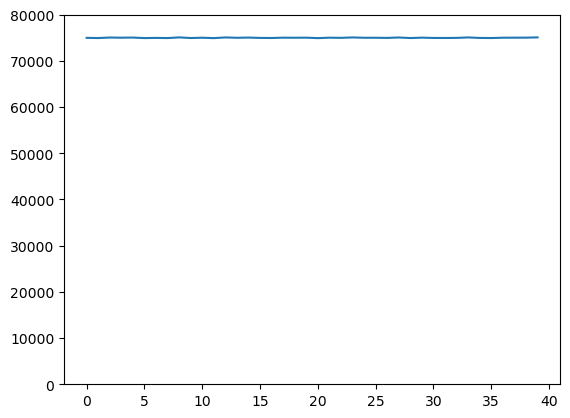

In [9]:
import pylab
p=pylab.plot(h)
pylab.ylim(ymin=0.,ymax=80000.)

In [10]:
for i in range(3):
    h,e=np.histogramdd(np.resize(randoms,(nrand//(i+1),i+1)),bins=40)
    print_info(h)

Dim.:  1 Ave counts: 75000.00 sqrt of Ave: 273.86 Std dev:   47.03 chi2 pvalue: 1.00000000
Dim.:  2 Ave counts:   937.50 sqrt of Ave:  30.62 Std dev:   11.65 chi2 pvalue: 1.00000000
Dim.:  3 Ave counts:    15.62 sqrt of Ave:   3.95 Std dev:    2.83 chi2 pvalue: 1.00000000


# Lets try a RNG from IBM widely used in the 60s and 70s ("RANDU")

In [11]:
lcg_randu=LCG(seed = 1, Multiplier = 65539, Addend = 0, Pmod = 2**31)

randoms=lcg_randu.randv(nrand)
h,e=np.histogram(randoms,bins=40)
print_info(h)

Dim.:  1 Ave counts: 75000.00 sqrt of Ave: 273.86 Std dev:  254.63 chi2 pvalue: 1.00000000


(0.0, 80000.0)

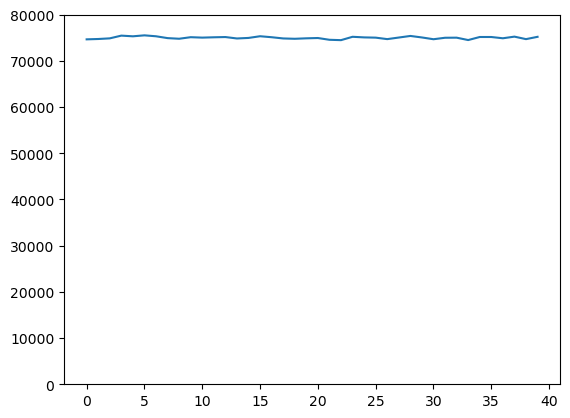

In [12]:
import pylab
p=pylab.plot(h)
pylab.ylim(ymin=0.,ymax=80000.)

In [13]:
for i in range(3):
    h,e=np.histogramdd(np.resize(randoms,(nrand//(i+1),i+1)),bins=40)  
    print_info(h)

Dim.:  1 Ave counts: 75000.00 sqrt of Ave: 273.86 Std dev:  254.63 chi2 pvalue: 1.00000000
Dim.:  2 Ave counts:   937.50 sqrt of Ave:  30.62 Std dev:   30.38 chi2 pvalue: 1.00000000
Dim.:  3 Ave counts:    15.62 sqrt of Ave:   3.95 Std dev:   24.76 chi2 pvalue: 0.00000000


# It looks like this RNG fails my basic set of tests. What went wrong? 

In [14]:
def plot_random(nrand,generator,nfig):
    randoms=generator.randv(nrand)
    fig = plt.figure(nfig,constrained_layout=True)
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=50, azim=-45)
    ax.scatter(randoms[0:nrand:3], 
               randoms[1:nrand:3], 
               randoms[2:nrand:3], s=3, zdir='y')

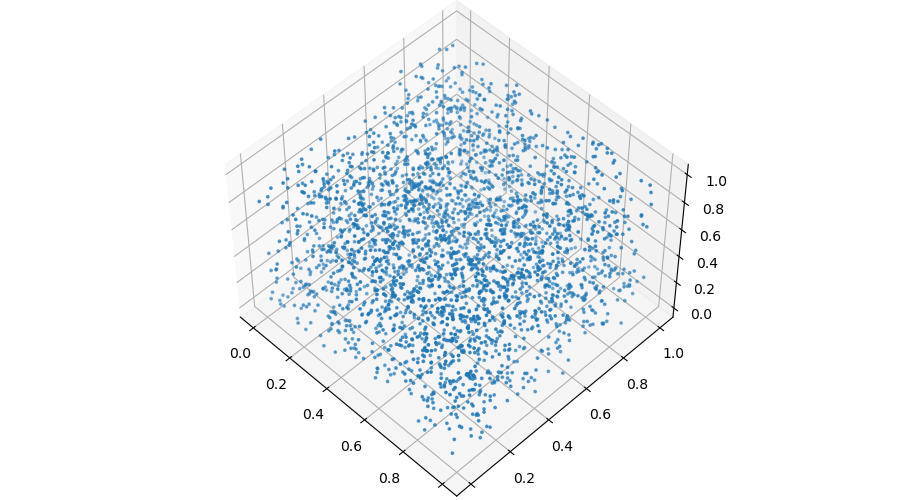

In [15]:
%matplotlib widget
import pylab as plt
plt.rcParams['figure.figsize'] = [9,5]
plot_random(9000,lcgdef,1)
#plt.xlim(xmin=0,xmax=1)
plt.show()

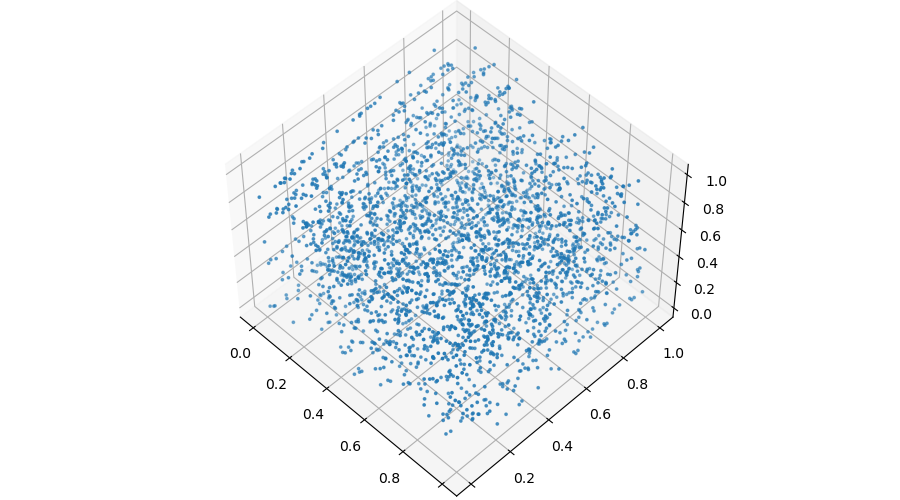

In [16]:
%matplotlib widget
import pylab as plt
plt.rcParams['figure.figsize'] = [9,5]
plot_random(9000,lcg_randu,2)
plt.show()

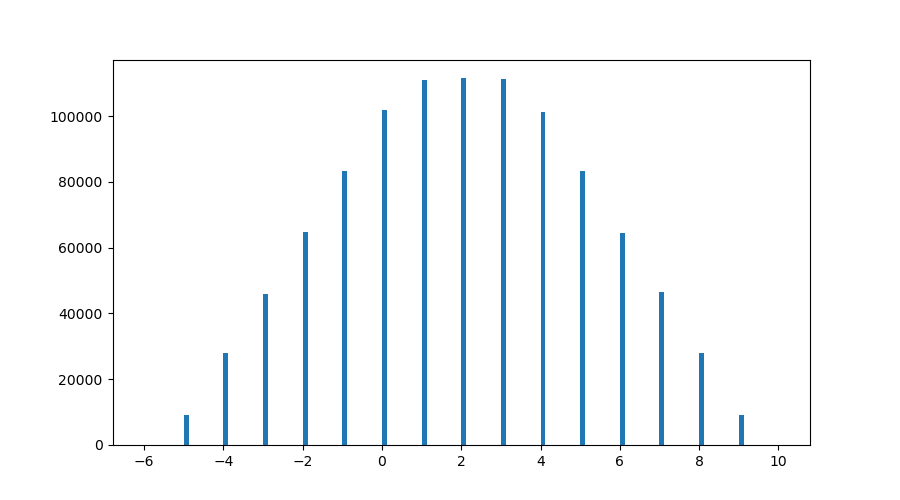

In [17]:
%matplotlib widget
randoms=lcg_randu.randv(nrand)
special=9*randoms[0::3]-6*randoms[1::3]+randoms[2::3]
fig=pylab.figure(3)
o=pylab.hist(special,range=(-6,10),bins=128)
pylab.show()

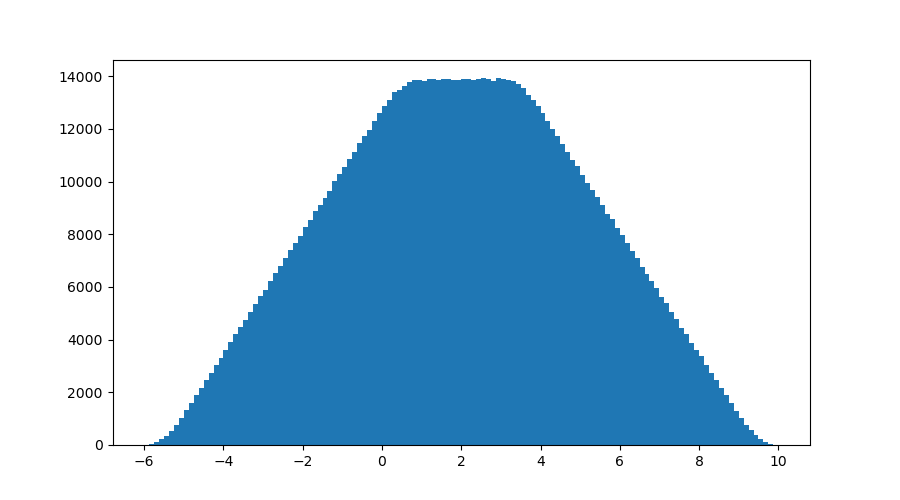

In [18]:
randoms=lcgdef.randv(nrand)
special=9*randoms[0::3]-6*randoms[1::3]+randoms[2::3]
fig=pylab.figure(14)
o=pylab.hist(special,range=(-6,10),bins=128)
pylab.show()

# Its important to know that your RNG is adequate for your work

  * RANDU was widely used (and very fast to execute) in the 60s and 70s. As RNG theory advanced, it became clear that it was very biased. 
  * No RNG is truly random. Hyperplanes are common and are "ok" if they are close together 

# Commonly used RNGs and their application to HEP

  * HEP has particularly stringent requirements on RNGs
    * Large and complex simulations
    * Ever growing data set sizes (eg, more simulation)
    * Large scale applications run on distributed computing systems and by non-expert users
    * Aspiration for reproducibility

# Combine multiple LCGs
  * Long sequence length (with a good choice of relatively-prime multipliers)
  * Small state, fast skips
  * Relatively slow(!)
  * No real theoretical grounding
  * Example: Wichmann-Hill (1982) combined 3 LCGs, expanded to 4 LCGs as tests became more stringent


# Lagged Fibonacci Generator (LFG)
<center>
    $S_n$ = $(S_{n-j} \; OP \; S_{n-k}) \mod m$
</center>
    
  * where $OP$ is a binary operation. eg *addition*, *subtraction*, *multiplication*, or *exclusive-or* (often with added sprinkles)
  * Choice of binary operation defines a family of generators
  * Quality and sequence length determined by the lag $k$ ($0<j<k$), large values can give very long sequences but require more memory for the generator state
  * Proper initialization is particularly important

# LFG example : Mersenne Twister

Mersenne Twister (Matsumoto & Nishimura, 1997) is a Lagged Fibonacci Generator with exclusive-or as the binary operation
  * Often recommended as a good tradeoff between speed and quality
  * Default generator for ROOT global gRandom
  * Can have very long sequence lengths
  * Skipping is possible but slow and not widely implemented
  * Independent sub-sequence algorithm not formally proved (or widely implemented)
  * Weak theoretical basis - fails some of the more stringent tests of the current TestU01 suite

# LFG example: RANLUX

Marsaglia & Zaman (1991) published RCARRY, an additive LFG with an additional “carry” term

Not a good quality PRNG, failed many tests, but this approach had interesting mathematical properties:
  * Equivalent to LCG with a very large multiplier
  * Matrix representation: $a(i+1)=A \times a(i) \mod l$, where $a(i)$ is a vector of size $k$
    * Lüscher (1994): with some additional constraints, dynamical system with Kolmogorov-Anosov mixing ￼ mixing theory provides guarantees of ergodicity, coverage, asymptotic independence
    * James (1994 CERNLIB implementation):  throw away enough iterations to approach asymptotic independence (“luxury” level $\approx 15$ iterations for a common choice of lags)
    * At high luxury levels, very high quality but relatively quite slow (⨉50 Mersenne Twister)
    
Has been the standard generator for HEP where highest quality is needed
“Full” detector simulations, Lattice QCD…

# MIXMAX generator

G. Savvidy & N. Ter-Arutyunyan-Savvidy (1986):
  * Design a dynamical system family that rapidly approaches asymptotic mixing
  * Naive implementation hopelessly slow.  K. Savvidy (2014) found tricks and optimizations that yield fast linear performance

Properties at high quality (state $\ge 240$ 64-bit words):
  * Speed competitive with Mersenne Twister for a single iteration
  * Asymptotic mixing in $\approx 5$ iterations
  * Sequence long enough ($>10^{4839}$) to allow guaranteed independent sub-sequences
  * Relatively efficient skipping ($n \log n$)
  * Slow initialization

Displacing RANLUX as the HEP standard for high quality random numbers:
  * CLHEP default, CMS choice for both fast and full sim

# Commonly used RNG libraries

  * C++ libraries
    * rand() - Avoid except for testing
    * boost 
    * CLHEP - HEP standard package for RNGs
    * STL numerics library (includes LCG, mersenne twister, ranlux) - https://en.cppreference.com/w/cpp/numeric/random
    
  * Python libraries
    * random
    * numpy.random
    
Writing codes that require random numbers? Choose carefully and be sure to understand how to properly seed generators (and how to get either reproducible or distinct results when rerunning your application)

In [20]:
import numpy as np
np.random.uniform(0,10,10)

array([6.04495544, 6.65293094, 0.1494606 , 8.53054088, 7.83590041,
       4.93414298, 6.14049821, 6.88187081, 6.70577396, 6.14539323])

# A word about parallelizing your RNG

  * Is it trivial to apply the OpenMP lectures to our LCG (or a C version of it..)?
  
No... Each random number depends on the previous one

In [ ]:
    def random(self):
        """Return a single random number between 0 and 1"""
        self.last = (self.multiplier * self.last + self.addend) % self.pmod
        return self.last/self.pmod

# Potential Solutions

  * Give every thread its own unique generator
    * These could be different generators from the same family, e.g. different LCG constants
    * Potential for unexpected interactions
  * One thread generates all the random numbers
    * Coordination overhead, blocking
  * Block methods, where every thread gets a well-defined subset of a sequence
    * Sequence splitting allocates contiguous blocks so that each thread gets its own non-overlapping sub-sequence
    * Leapfrog divides the sequence round-robin, so thread n gets the sequence of entries where the sequence number modulo the number of threads is n
    * Block methods can be implemented efficiently for LCG and some other generators

Getting reproducible results independent of the number of threads can be especially tricky

# Exercise 2

Most modern random number libraries have functions to get random numbers distributed according many functions rather than just a flat [0,1] distribution. To understand better how these work, use our LCG RNG to create a RNG for a Poisson distribution

<center>
    $PDF(\lambda) = {{\lambda^k e^{-k}} \over {k!}}$ 
    </center>

Specifically, implement this function without using numpy/scipy/etc functions. Make sure it works for small and large values of the mean (eg, 50) 
        

In [ ]:
def random_poisson(self, m):
        """Return a single random number according to a Poisson distribution with mean m"""
        


In [21]:
import math
class LCGWP:
    def __init__(self, seed = 1, Multiplier = 1366, Addend = 150889, Pmod = 714025):
        """Create an LCG instance"""
        self.multiplier = Multiplier
        self.addend = Addend
        self.pmod = Pmod
        self.setseed(seed)
    
    def setseed(self, seed):
        self.last = seed

    def random(self):
        """Return a single random number between 0 and 1"""
        self.last = (self.multiplier * self.last + self.addend) % self.pmod
        return self.last/self.pmod

    def random_poisson(self, m):
        """Return a single random number according to a Poisson distribution with mean m"""
        rand=self.random()
        k=0
        cdf=0.
        while(1):
            pdf=math.exp(-1.0*m)
            for i in range(1,k+1):
                pdf=pdf*m/i
            cdf=cdf+pdf
            if cdf > rand: break
            k=k+1
        return k
    
    def randv(self, size = 1):
        """Return a numpy array of random numbers between 0 and 1"""
        v = np.empty(size)
        for i in range(size):
            v[i] = self.random()
        return v
    
    def randv_poisson(self, m, size = 1):
        """Return a numpy array of random numbers between 0 and 1"""
        v = np.empty(size,int)
        for i in range(size):
            v[i] = self.random_poisson(m)
        return v

lcg=LCGWP()
print(lcg.random_poisson(5.))
print(lcg.randv_poisson(5.,10))
print(lcg.randv_poisson(0.5,10))
print(lcg.randv_poisson(50.,10))

myrands=lcg.randv_poisson(5.,10000)    

3
[5 6 7 2 6 3 4 6 3 3]
[1 0 0 0 0 1 0 1 1 1]
[40 56 36 62 69 54 56 41 53 52]


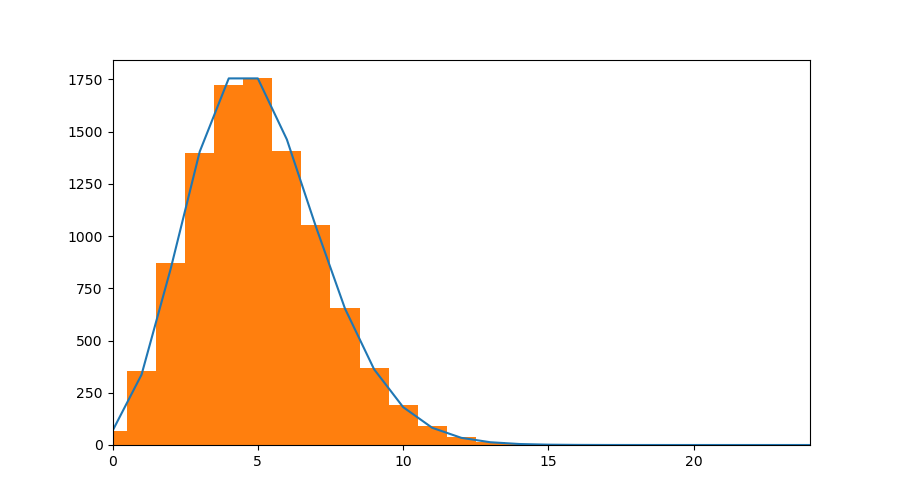

In [22]:
#lets check our work..
from scipy.stats import poisson
import numpy as np
import matplotlib.pyplot as plt
 
# creating a numpy array for x-axis
x = np.arange(0, 25)
 
# poisson distribution data for y-axis
pgen = poisson(5)
y = pgen.pmf(x)

# plotting the graph
plt.figure(15)
plt.clf()
p=plt.plot(x, 10000*y)
p2=plt.hist(myrands,bins=25,range=(-0.5,24.5))
plt.xlim(xmin=x[0],xmax=x[-1])
plt.ylim(ymin=0.)
plt.show() 